# Perturb-seq vs FACS screens on TNFa

In [3]:
import anndata
import pandas as pd
import numpy as np                                                                                                                                                                                                      
from scipy.sparse import vstack, csr_matrix      
from scipy.sparse import hstack  
from scipy.stats import pearsonr        
import pertpy as pt          

import matplotlib.pyplot as plt
import seaborn as sns


## Prep TNF expression data

In [4]:
datadir = '/mnt/oak/users/emma/data/Macs_perturbseq/'

In [5]:
# Read CRISPR screen on TNFa results
screen_df = pd.read_table("metadata/Paired_hi_vs_low_2026-01-09.gene_summary.txt")
measured_KOs_screen = screen_df['id'].unique().tolist()
len(measured_KOs_screen)

584

Input files are downloaded from dropbox https://www.dropbox.com/scl/fo/4h3qmkcu6jn5o2gl1dqcc/AJTFd7r2Xf5QxNATNw_9zKE?rlkey=bcl715a781qcp4am72ephz7nb&e=1&st=cup4o802&dl=0 

In [ ]:
# Read Perturb-seq data for TNF expression 
# this section is using some lazy loading tricks to not blow up memory
# with new version of saved .h5ad with more efficient storage of guide matrix should make things easier 
exp_ls = [
    'Mac_L01_Mac_LPS', 
    'Mac_L02_Mac_LPS', 'Mac_L03_Mac_LPS', 'Mac_L04_Mac_LPS']
    
for exp_name in exp_ls:
    lane_id = exp_name.split('_')[1]
    adata = anndata.experimental.read_lazy(f'{datadir}/{exp_name}/Mac_{lane_id}_gex_multiguide.h5ad')

    adata.obs = adata.obs.to_dataframe()
    adata.var = adata.var.to_dataframe()

    # Get TNFa expression
    adata_tnf = anndata.AnnData(
        X = adata[:, "TNF"].layers['counts'].compute(),
        obs = adata.obs,
    )

    measured_KOs_perturbseq = adata.obsm['guide_matrix'].columns.str.split("-").str[0]
    measured_KOs_perturbseq = measured_KOs_perturbseq.unique()
    measured_KOs = np.intersect1d(measured_KOs_perturbseq, measured_KOs_screen)
    measured_KOs = np.append(measured_KOs, "NTC")

    # Get all guides targeting one of the measured_KOs
    keep_guides = [col for col in adata.obsm['guide_matrix'].columns if col.split("-")[0] in measured_KOs]
    ds = adata.obsm['guide_matrix'][keep_guides]
    keep_cells = ds.to_array(dim='variable').sum(dim='variable') > 0
                                                                                                                                                                                                                                        
    chunk_size = 1000                                                                                                                                                                                                                    
    chunks = []                                                                                                                                                                                                                           
                                                                                                                                                                                                                                        
    from tqdm import tqdm
    for i in tqdm(range(0, len(ds._index), chunk_size)):
        chunk = ds.isel(_index=slice(i, i + chunk_size))                                                                                                                                                                                  
        chunk_dense = chunk.to_array(dim='variable').T.values                                                                                                                                                                             
        chunks.append(csr_matrix(chunk_dense))                                                                                                                                                                                            
                                                                                                                                                                                                                                        
    sparse_matrix = vstack(chunks, format='csr')
    adata_tnf.obsm['guide_matrix'] = sparse_matrix
    guide_ids = ds.columns.copy()
    adata_tnf.uns['guide_ids'] = guide_ids.tolist()
    adata_tnf.write_h5ad(f'{exp_name}_TNF_processed.h5ad')

## Parse data

In [4]:
exp_ls = [
    'Mac_L01_Mac_LPS', 
    'Mac_L02_Mac_LPS', 'Mac_L03_Mac_LPS', 'Mac_L04_Mac_LPS']
    
ad_ls = []
for exp_name in exp_ls:
    ad = anndata.read_h5ad(f'{exp_name}_TNF_processed.h5ad')
    ad_ls.append(ad)
    
# Get common guide_ids across all objects in ad_ls
all_gids = [set(a.uns['guide_ids']) for a in ad_ls]
common_gids = set.intersection(*all_gids)

# For each AnnData object in ad_ls, get the columns from obsm['guide_matrix'] that correspond to guide_ids in common_gids
for a in ad_ls:
    gids = a.uns['guide_ids']
    gids = pd.Index(gids)
    common_idx = gids.get_indexer_for(common_gids)
    # In case there are -1s if gids is not sorted the same as common_gids
    is_valid = common_idx != -1
    valid_common_gids = np.array(list(common_gids))[is_valid]
    valid_common_idx = common_idx[is_valid]
    # Select columns from the guide_matrix corresponding to valid_common_idx
    # If using pandas dataframe as guide_matrix:
    if hasattr(a.obsm['guide_matrix'], 'iloc'):
        a.obsm['common_guide_matrix'] = a.obsm['guide_matrix'].iloc[:, valid_common_idx]
    else:
        # If guide_matrix is numpy array or sparse matrix/scipy
        from scipy.sparse import issparse
        if issparse(a.obsm['guide_matrix']):
            a.obsm['common_guide_matrix'] = a.obsm['guide_matrix'][:, valid_common_idx]
        else:
            a.obsm['common_guide_matrix'] = a.obsm['guide_matrix'][:, valid_common_idx]


In [ ]:
# Merge data from all lanes and guide assignments
adata_tnf = anndata.concat(ad_ls)
adata_tnf.uns['guide_ids'] = list(common_gids)

sparse_matrix = adata_tnf.obsm['common_guide_matrix']
guide_ids = adata_tnf.uns['guide_ids']

# Make design matrix mapping cells to targeted gene
guide_ids_series = pd.Series(guide_ids)
target_gene = guide_ids_series.str.split('-').str[0]

guide_to_gene = pd.DataFrame({'guide_id': guide_ids, 'target_gene': target_gene})
unique_genes = guide_to_gene['target_gene'].unique()
gene_to_indices = {gene: guide_to_gene.index[guide_to_gene['target_gene'] == gene].tolist() for gene in unique_genes}

summed_sparse_cols = []
for gene in unique_genes:
    col_indices = gene_to_indices[gene]
    summed_col = sparse_matrix[:, col_indices].sum(axis=1)
    summed_sparse_cols.append(csr_matrix(summed_col))

target_design_matrix = hstack(summed_sparse_cols, format='csr')
target_design_matrix = pd.DataFrame(target_design_matrix.toarray(), columns = unique_genes, index=adata_tnf.obs_names)
target_design_matrix[target_design_matrix != 0] = 1
target_design_matrix.head()

,PIP4K2A,C3,WDR61,AGPAT1,MAPK1,DDAH2,CBLL1,NTC,TMEM176A,DHX15,...,CEBPB,CARD10,IRAK2,AICDA,DGKA,KRAS,CASP4,TXNDC17,ERCC6,S100A9
AAACAAGCAAACAATCACAGTCTG-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAAGCAAACCCAAAACGCCGA-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAAGCAAACCCAAACAGTCTG-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAAGCAAACCCAAATCATGTG-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACAAGCAAACCGTAACAGTCTG-1_Mac_LPS_Mac_L01,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## DE test for each target

### Target vs rest test
Compare cells with targeting guide for one gene vs all other cells (probably fairest comparison, both case and control cells have the same mix of other perturbations)

In [ ]:
all_res = []
for t in target_design_matrix.columns:
    adata_tnf.obs['target_oi'] = np.where(target_design_matrix[t] == 1, t, 'other')
    pds2 = pt.tl.WilcoxonTest(adata=adata_tnf, design='~target_oi')
    t_res = pds2.compare_groups(adata_tnf, column='target_oi', baseline='other', groups_to_compare=[t])
    all_res.append(t_res)

In [ ]:
res = pd.concat(all_res)
res['target_gene'] = res['comparison'].str.split("_vs").str[0]
res.to_csv("results/DE_t_on_TNF.t_vs_other.csv")
res[res['target_gene'] == 'TNF']

,variable,p_value,log_fc,comparison,adj_p_value,target_gene
0,0,0.58785,-0.016362,TNF_vs_other,0.58785,TNF


In [ ]:
res = pd.read_csv("results/DE_t_on_TNF.t_vs_other.csv", index_col=0)

In [9]:
res[res.adj_p_value < 0.1].head()

,variable,p_value,log_fc,comparison,adj_p_value,target_gene
0,0,3.344196e-20,0.076389,NTC_vs_other,3.344196e-20,NTC
0,0,2.771023e-03,0.198544,TMEM176A_vs_other,2.771023e-03,TMEM176A
0,0,4.836143e-02,-0.023359,IL10_vs_other,4.836143e-02,IL10
0,0,1.303565e-02,0.085554,RAB18_vs_other,1.303565e-02,RAB18
0,0,5.425400e-02,0.107203,CD38_vs_other,5.425400e-02,CD38


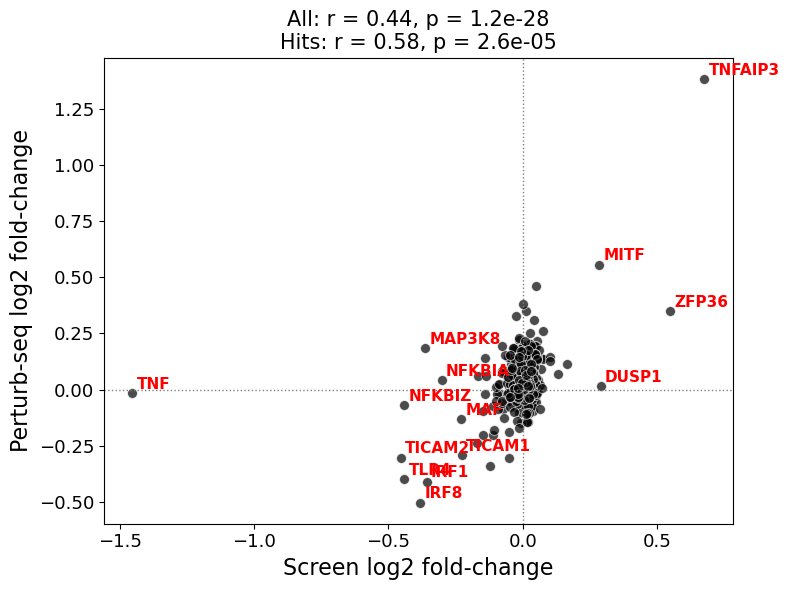

In [ ]:

screen_df['hit'] = (screen_df['neg|fdr'] < 0.1) | (screen_df['pos|fdr'] < 0.1)
pl_screen_df = screen_df[['id', 'neg|lfc', 'hit']]
pl_screen_df.columns = ['target_gene', 'screen_lfc', 'screen_hit']

pl_df = pd.merge(res, pl_screen_df)
hits_pl_df = pl_df[pl_df['screen_hit']].copy()


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pl_df,
    x='screen_lfc',
    y='log_fc',
    color='black',
    alpha=0.7,
    s=50,
)

# Annotate hits with target_gene names, using adjustText to avoid overlaps
from adjustText import adjust_text

texts = []
for _, row in hits_pl_df.iterrows():
    if np.abs(row['screen_lfc']) > 0.2:
        plt.annotate(
            row['target_gene'],
            (row['screen_lfc'], row['log_fc']),
            fontsize=11,
            fontweight='bold',
            color='red',
            xytext=(3, 3),
            textcoords='offset points'
        )
        
# Calculate Pearson correlation coefficient and p-value
corr_coef, p_val = pearsonr(pl_df['screen_lfc'], pl_df['log_fc'])
signif_corr_coef, signif_p_val = pearsonr(hits_pl_df['screen_lfc'], hits_pl_df['log_fc'])

# Improve axis labels and font sizes
plt.xlabel('Screen log2 fold-change', fontsize=16)
plt.ylabel('Perturb-seq log2 fold-change', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.axhline(0, color='gray', linestyle='dotted', linewidth=1)
plt.axvline(0, color='gray', linestyle='dotted', linewidth=1)

# Add correlation coefficients to the plot title and as subtitle for significant hits
plt.title(
    f"All: r = {corr_coef:.2f}, p = {p_val:.2g}\nHits: r = {signif_corr_coef:.2f}, p = {signif_p_val:.2g}",
    fontsize=15
)
plt.tight_layout()
plt.show()

### Target vs NTCs test
Restrict controls to cells with single NTC guide

In [56]:
adata_tnf.obs['sgRNA_type'].value_counts()

sgRNA_type
multi sgRNA         546249
Single sgRNA         99161
single NTC sgRNA     25783
Name: count, dtype: int64

In [ ]:
all_res = []
for t in target_design_matrix.columns:
    adata_tnf.obs['target_oi'] = np.where(target_design_matrix[t] == 1, t, 'other')
    adata_tnf.obs['target_oi'] = np.where(adata_tnf.obs['sgRNA_type'] == 'single NTC sgRNA', 'NTC', adata_tnf.obs['target_oi'])
    pds2 = pt.tl.WilcoxonTest(adata=adata_tnf, design='~target_oi')
    t_res = pds2.compare_groups(adata_tnf, column='target_oi', baseline='NTC', groups_to_compare=[t])
    all_res.append(t_res)

In [ ]:
res = pd.concat(all_res)
res['target_gene'] = res['comparison'].str.split("_vs").str[0]
res.to_csv("results/DE_t_on_TNF.t_vs_singleNTC.csv")
res[res['target_gene'] == 'TNF']

,variable,p_value,log_fc,comparison,adj_p_value,target_gene
0,0,0.932369,0.061759,TNF_vs_NTC,0.932369,TNF


In [64]:
res[res.adj_p_value < 0.1]

,variable,p_value,log_fc,comparison,adj_p_value,target_gene
0,0,2.672458e-02,0.275549,TMEM176A_vs_NTC,2.672458e-02,TMEM176A
0,0,8.651602e-02,0.163130,RAB18_vs_NTC,8.651602e-02,RAB18
0,0,2.865419e-03,0.225026,NLRX1_vs_NTC,2.865419e-03,NLRX1
0,0,7.654757e-02,-0.052353,MAF_vs_NTC,7.654757e-02,MAF
0,0,2.917244e-02,0.166028,EGR1_vs_NTC,2.917244e-02,EGR1
...,...,...,...,...,...,...
0,0,3.696884e-02,0.103436,SNX13_vs_NTC,3.696884e-02,SNX13
0,0,2.459412e-02,-0.047621,RNF31_vs_NTC,2.459412e-02,RNF31
0,0,6.199179e-19,0.632296,MITF_vs_NTC,6.199179e-19,MITF
0,0,1.334781e-02,0.041231,BPTF_vs_NTC,1.334781e-02,BPTF


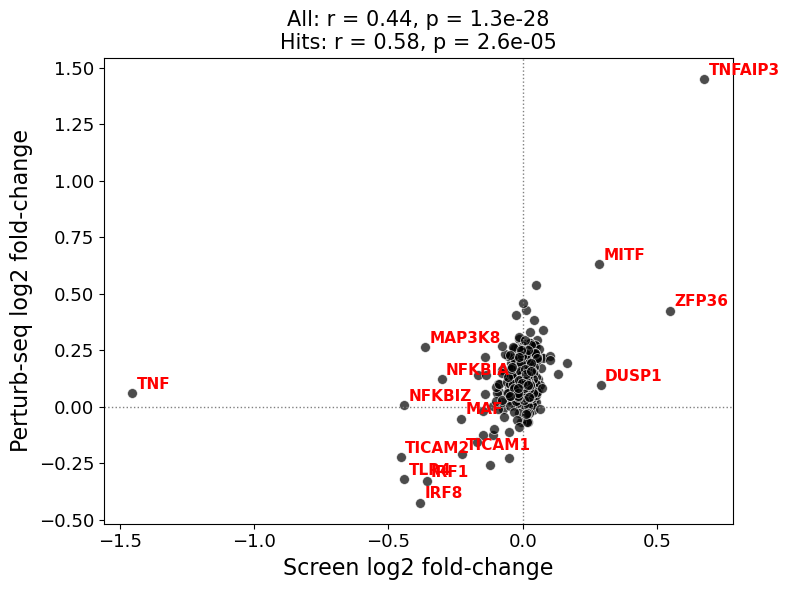

In [65]:

screen_df['hit'] = (screen_df['neg|fdr'] < 0.1) | (screen_df['pos|fdr'] < 0.1)
pl_screen_df = screen_df[['id', 'neg|lfc', 'hit']]
pl_screen_df.columns = ['target_gene', 'screen_lfc', 'screen_hit']

pl_df = pd.merge(res, pl_screen_df)
hits_pl_df = pl_df[pl_df['screen_hit']].copy()

from scipy.stats import pearsonr

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pl_df,
    x='screen_lfc',
    y='log_fc',
    color='black',
    alpha=0.7,
    s=50,
)

# Annotate hits with target_gene names, using adjustText to avoid overlaps
from adjustText import adjust_text

texts = []
for _, row in hits_pl_df.iterrows():
    if np.abs(row['screen_lfc']) > 0.2:
        plt.annotate(
            row['target_gene'],
            (row['screen_lfc'], row['log_fc']),
            fontsize=11,
            fontweight='bold',
            color='red',
            xytext=(3, 3),
            textcoords='offset points'
        )
        
# Calculate Pearson correlation coefficient and p-value
corr_coef, p_val = pearsonr(pl_df['screen_lfc'], pl_df['log_fc'])
signif_corr_coef, signif_p_val = pearsonr(hits_pl_df['screen_lfc'], hits_pl_df['log_fc'])

# Improve axis labels and font sizes
plt.xlabel('Screen log2 fold-change', fontsize=16)
plt.ylabel('Perturb-seq log2 fold-change', fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.axhline(0, color='gray', linestyle='dotted', linewidth=1)
plt.axvline(0, color='gray', linestyle='dotted', linewidth=1)

# Add correlation coefficients to the plot title and as subtitle for significant hits
plt.title(
    f"All: r = {corr_coef:.2f}, p = {p_val:.2g}\nHits: r = {signif_corr_coef:.2f}, p = {signif_p_val:.2g}",
    fontsize=15
)
plt.tight_layout()
plt.show()

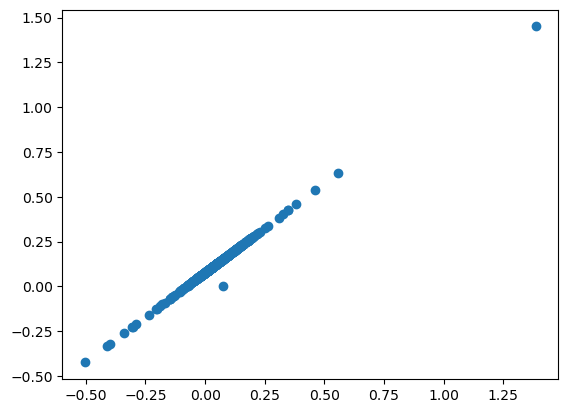

In [77]:
res1 = pd.read_csv("DE_t_on_TNF.t_vs_other.csv")
res2 = pd.read_csv("DE_t_on_TNF.t_vs_singleNTC.csv")

# Compare log_fc in each, after merging on available key columns
merge_cols = ['target_gene'] if 'target_gene' in res1.columns and 'target_gene' in res2.columns else ['variable']
comp_df = pd.merge(
    res1[merge_cols + ['log_fc']],
    res2[merge_cols + ['log_fc']],
    on=merge_cols,
    suffixes=('_vs_other', '_vs_singleNTC')
)

plt.scatter(comp_df['log_fc_vs_other'], comp_df['log_fc_vs_singleNTC'])
